In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import ParameterGrid
from torch.utils.data import DataLoader
from vae.datasets_randomized import VolSurfaceDataSetRand, CustomBatchSampler
from vae.cvae_with_mem_randomized import CVAEMemRand
from vae.utils import *
from eval_scripts.eval_utils import *
import os, sys
from typing import Dict
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
set_seeds(0)
torch.set_default_dtype(torch.float64)

In [3]:
data = np.load("data/vol_surface_with_ret.npz")
vol_surf_data = data["surface"]
ret_data = data["ret"]
level_data = data["levels"]
skew_data = data["skews"]
slope_data = data["slopes"]
ex_data = np.concatenate([ret_data[...,np.newaxis], skew_data[...,np.newaxis], slope_data[...,np.newaxis]], axis=-1)
print(ex_data.shape)

(5822, 3)


In [4]:
def generate_latents_single_day(model: CVAEMemRand, x: Dict[str, torch.Tensor]):
    surface = x["surface"].to(model.device)
    if len(surface.shape) == 3:
        # unbatched data
        surface = surface.unsqueeze(0)
    B = surface.shape[0]
    T = surface.shape[1]
    C = T - 1
    ctx_surface = surface[:, :C, :, :] # c
    ctx_encoder_input = {"surface": ctx_surface}

    encoder_input = {"surface": surface}
    if "ex_feats" in x:
        ex_feats = x["ex_feats"].to(model.device)
        if len(ex_feats.shape) == 2:
            ex_feats = ex_feats.unsqueeze(0)
        ctx_ex_feats = ex_feats[:, :C, :]
        ctx_encoder_input["ex_feats"] = ctx_ex_feats
        encoder_input["ex_feats"] = ex_feats

    ctx_embedding = model.ctx_encoder(ctx_encoder_input).detach().cpu().numpy() # embedded c (B, C, n)
    z_mean, z_log_var, z = model.encoder(encoder_input) # P(z|c,x), (B, T, latent_dim)

    return {
        "ctx": ctx_embedding, 
        "z_mean": z_mean.detach().cpu().numpy(), 
        "z_log_var": z_log_var.detach().cpu().numpy()
    }

def generate_latents_multi_day(model, fp, surf_data, ex_data=None, ctx_len = 3, start_day = 3, days_to_generate=5300):
    if not os.path.exists(fp):
        all_day_ctx_embedding = np.zeros((days_to_generate, ctx_len, model.config["latent_dim"]))
        all_day_z_mean = np.zeros((days_to_generate, ctx_len + 1, model.config["latent_dim"]))
        all_day_z_log_var = np.zeros((days_to_generate, ctx_len + 1, model.config["latent_dim"]))

        for day in range(start_day, start_day+days_to_generate):
            if day % 1000 == 0:
                print(f"Generating day {day}")
                
            x = {
                "surface": torch.tensor(surf_data[day-start_day:day+1]),
            }
            if model.config["ex_feats_dim"] > 0:
                x["ex_feats"] = torch.tensor(ex_data[day-start_day:day+1])
            output_dict = generate_latents_single_day(model, x)
            all_day_ctx_embedding[day - start_day, ...] = output_dict["ctx"].reshape((ctx_len, model.config["latent_dim"]))
            all_day_z_mean[day - start_day, ...] = output_dict["z_mean"].reshape((ctx_len + 1, model.config["latent_dim"]))
            all_day_z_log_var[day - start_day, ...] = output_dict["z_log_var"].reshape((ctx_len + 1, model.config["latent_dim"]))
        np.savez(fp,
            ctx_emb=all_day_ctx_embedding,
            z_mean=all_day_z_mean,
            z_log_var=all_day_z_log_var)
    else:
        gen_data = np.load(fp)
        all_day_ctx_embedding = gen_data["ctx_emb"]
        all_day_z_mean = gen_data["z_mean"]
        all_day_z_log_var = gen_data["z_log_var"]
    
    return all_day_ctx_embedding, all_day_z_mean, all_day_z_log_var

In [5]:
periods = [
    pd.date_range("2001-04-01", "2001-11-30"),
    pd.date_range("2008-01-01", "2009-06-30"),
    pd.date_range("2020-03-01", "2020-04-30"),
]

# loss

In [6]:
generated_data = np.load("test_spx/2023_08_27/model_1_gen3.npz")
generated_surfaces = np.mean(generated_data["surfaces"], axis=1)
generated_rets = np.mean(generated_data["ex_feats"][:, :, 0], axis=1)
generated_skews = (generated_surfaces[:, 3, 1] + generated_surfaces[:, 3, 3]) / 2 - generated_surfaces[:, 3, 2]
generated_slopes = generated_surfaces[:, 4, 2] - generated_surfaces[:, 1, 2]
print(generated_surfaces.shape)
print(generated_skews.shape)
print(generated_slopes.shape)
generated_ex_data = np.concatenate([generated_rets[...,np.newaxis], generated_skews[...,np.newaxis], generated_slopes[...,np.newaxis]], axis=-1)
print(generated_ex_data.shape)

(5300, 5, 5)
(5300,)
(5300,)
(5300, 3)


In [7]:
file_path = "test_spx/2023_08_27/model_1.pt"
model_data = torch.load(file_path) # latent_dim=5, surface_hidden=[5,5,5], mem_hidden=100
model_config = model_data["model_config"]
model = CVAEMemRand(model_config)
model.load_weights(dict_to_load=model_data)

In [8]:
ctx_embedding, z_mean, z_log_var = generate_latents_multi_day(model, 
                                                            "test_spx/2023_08_27/model1_enc_latent.npz",
                                                            vol_surf_data, ex_data)
ctx_embedding2, z_mean2, z_log_var2 = generate_latents_multi_day(model, 
                                                                 "test_spx/2023_08_27/model1_gen_enc_latent.npz",
                                                                generated_surfaces, generated_ex_data,
                                                                3, 3, 5300-3)

In [9]:
ctx_emb = ctx_embedding.reshape((-1, ctx_embedding.shape[1] * ctx_embedding.shape[2]))
pca_ctx_emb = PCA(n_components=2).fit_transform(ctx_emb)
print(pca_ctx_emb.shape)
# z_mu = all_day_z_mean[:, -1, :]
z_mu = z_mean.reshape((-1, z_mean.shape[1] * z_mean.shape[2]))
pca_z_mu = PCA(n_components=1).fit_transform(z_mu)
print(pca_z_mu.shape)
# z_log_sig = all_day_z_log_var[:, -1, :]
z_log_sig = z_log_var.reshape((-1, z_log_var.shape[1] * z_log_var.shape[2]))
pca_z_log_sig = PCA(n_components=1).fit_transform(z_log_sig)
print(pca_z_log_sig.shape)

(5300, 2)
(5300, 1)
(5300, 1)


In [10]:
ctx_emb2 = ctx_embedding2.reshape((-1, ctx_embedding2.shape[1] * ctx_embedding2.shape[2]))
pca_ctx_emb2 = PCA(n_components=2).fit_transform(ctx_emb2)
print(pca_ctx_emb2.shape)
# z_mu = all_day_z_mean[:, -1, :]
z_mu2 = z_mean2.reshape((-1, z_mean2.shape[1] * z_mean2.shape[2]))
pca_z_mu2 = PCA(n_components=1).fit_transform(z_mu2)
print(pca_z_mu2.shape)
# z_log_sig = all_day_z_log_var[:, -1, :]
z_log_sig2 = z_log_var2.reshape((-1, z_log_var2.shape[1] * z_log_var2.shape[2]))
pca_z_log_sig2 = PCA(n_components=1).fit_transform(z_log_sig2)
print(pca_z_log_sig2.shape)

(5297, 2)
(5297, 1)
(5297, 1)


In [11]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
df = spx_df.loc[3:5303-1, ["date"]].reset_index(drop=True).copy()
df["ctx_dim0"] = pca_ctx_emb[:, 0]
df["ctx_dim1"] = pca_ctx_emb[:, 1]
df["z_mu"] = pca_z_mu[:, 0]
df["z_log_sig"] = pca_z_log_sig[:, 0]

df.loc[3:, "gen_ctx_dim0"] = pca_ctx_emb2[:, 0]
df.loc[3:, "gen_ctx_dim1"] = pca_ctx_emb2[:, 1]
df.loc[3:, "gen_z_mu"] = pca_z_mu2[:, 0]
df.loc[3:, "gen_z_log_sig"] = pca_z_log_sig2[:, 0]
df.head()

,date,ctx_dim0,ctx_dim1,z_mu,z_log_sig,gen_ctx_dim0,gen_ctx_dim1,gen_z_mu,gen_z_log_sig
0,2000-01-06,1.730464,-0.214969,-3.752330,3.631871,NaN,NaN,NaN,NaN
1,2000-01-07,1.401259,-1.101603,-0.270283,2.016242,NaN,NaN,NaN,NaN
2,2000-01-10,1.651352,-1.491048,1.684814,-0.885008,NaN,NaN,NaN,NaN
3,2000-01-11,1.195744,0.603546,1.637212,-2.109214,1.756086,-1.596048,0.000670,-0.028852
4,2000-01-12,1.680091,-1.086646,-1.170822,0.085441,1.612911,-0.020243,0.064718,0.085899


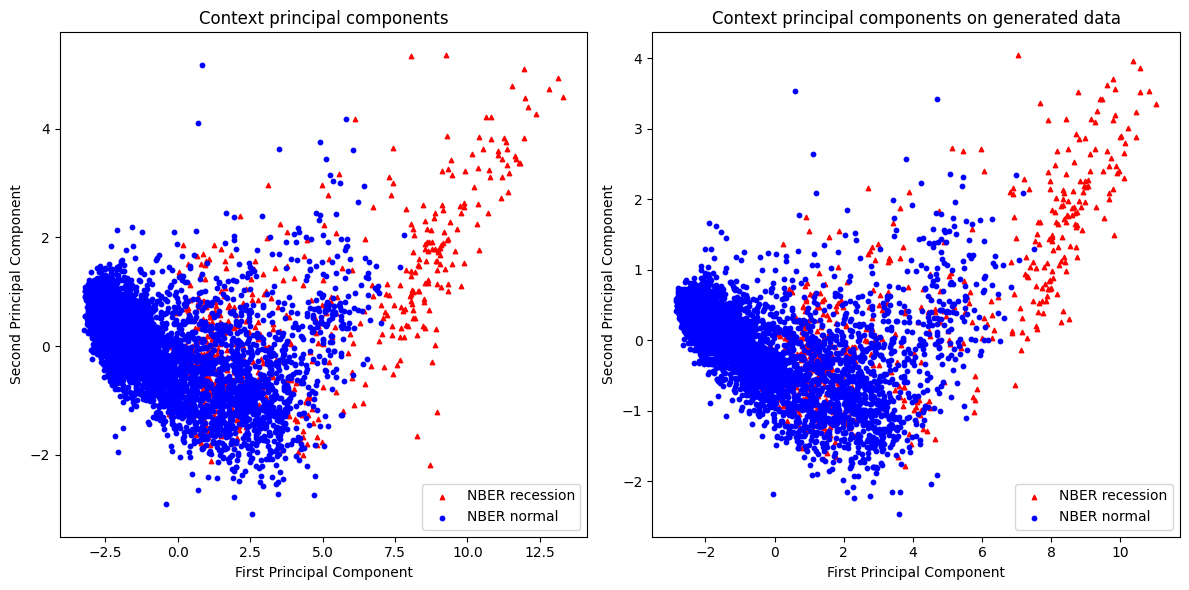

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

subset_df = df[(df["date"].isin(periods[0]) | df["date"].isin(periods[1]) | df["date"].isin(periods[2]))].copy()
ax[0].scatter(subset_df["ctx_dim0"], subset_df["ctx_dim1"], s=10, c="red", label="NBER recession", marker="^")
ax[1].scatter(subset_df["gen_ctx_dim0"], subset_df["gen_ctx_dim1"], s=10, c="red", label="NBER recession", marker="^")

subset_df = df[~(df["date"].isin(periods[0]) | df["date"].isin(periods[1]) | df["date"].isin(periods[2]))].copy()
ax[0].scatter(subset_df["ctx_dim0"], subset_df["ctx_dim1"], s=10, c="blue", label="NBER normal")
ax[1].scatter(subset_df["gen_ctx_dim0"], subset_df["gen_ctx_dim1"], s=10, c="blue", label="NBER normal")

ax[0].set_xlabel("First Principal Component")
ax[0].set_ylabel("Second Principal Component")
ax[0].set_title("Context principal components")
ax[0].legend(loc="lower right")
ax[1].set_xlabel("First Principal Component")
ax[1].set_ylabel("Second Principal Component")
ax[1].set_title("Context principal components on generated data")
ax[1].legend(loc="lower right")
plt.tight_layout()
plt.show()

# no loss

In [5]:
file_path = "test_spx/2023_08_27/model_0.pt"
model_data = torch.load(file_path) # latent_dim=5, surface_hidden=[5,5,5], mem_hidden=100
model_config = model_data["model_config"]
model_no_loss = CVAEMemRand(model_config)
model_no_loss.load_weights(dict_to_load=model_data)

In [13]:
all_day_ctx_embedding, all_day_z_mean, all_day_z_log_var = generate_latents_multi_day(model_no_loss, 
                                                                                      "test_spx/2023_08_27/model0_enc_latent.npz")

Generating day 500
Generating day 1000
Generating day 1500
Generating day 2000
Generating day 2500
Generating day 3000
Generating day 3500
Generating day 4000
Generating day 4500
Generating day 5000


In [14]:
ctx_emb = all_day_ctx_embedding.reshape((-1, all_day_ctx_embedding.shape[1] * all_day_ctx_embedding.shape[2]))
pca_ctx_emb = PCA(n_components=2).fit_transform(ctx_emb)
print(pca_ctx_emb.shape)
# z_mu = all_day_z_mean[:, -1, :]
z_mu = all_day_z_mean.reshape((-1, all_day_z_mean.shape[1] * all_day_z_mean.shape[2]))
pca_z_mu = PCA(n_components=1).fit_transform(z_mu)
print(pca_z_mu.shape)
# z_log_sig = all_day_z_log_var[:, -1, :]
z_log_sig = all_day_z_log_var.reshape((-1, all_day_z_log_var.shape[1] * all_day_z_log_var.shape[2]))
pca_z_log_sig = PCA(n_components=1).fit_transform(z_log_sig)
print(pca_z_log_sig.shape)

(5300, 2)
(5300, 1)
(5300, 1)


In [15]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
df = spx_df.loc[3:5303-1, ["date"]].copy()
df["ctx_dim0"] = pca_ctx_emb[:, 0]
df["ctx_dim1"] = pca_ctx_emb[:, 1]
df["z_mu"] = pca_z_mu[:, 0]
df["z_log_sig"] = pca_z_log_sig[:, 0]
df.head()

,date,ctx_dim0,ctx_dim1,z_mu,z_log_sig
3,2000-01-06,1.787431,0.833079,3.504608,-1.287950
4,2000-01-07,1.996878,-1.619047,-0.156263,0.417085
5,2000-01-10,1.963422,-2.014067,-1.975526,2.157776
6,2000-01-11,1.190521,1.111218,-2.143557,1.564751
7,2000-01-12,2.249971,-1.412028,0.731949,0.190970


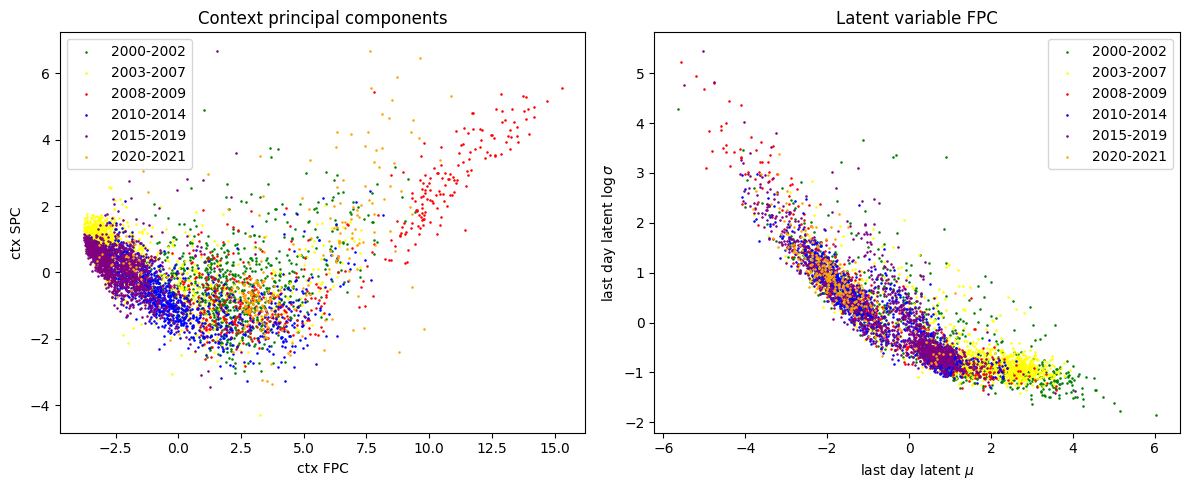

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for period_date, period_title, period_range, color in periods:
    subset_df = df[df["date"].isin(period_range)].copy()
    ax[0].scatter(subset_df["ctx_dim0"], subset_df["ctx_dim1"], s=0.7, c=color, label=period_date)
    ax[1].scatter(subset_df["z_mu"], subset_df["z_log_sig"], s=0.7, c=color, label=period_date)

ax[0].set_xlabel("ctx FPC")
ax[0].set_ylabel("ctx SPC")
ax[0].set_title("Context principal components")
ax[0].legend()
ax[1].set_xlabel("last day latent $\mu$")
ax[1].set_ylabel("last day latent $\log \sigma$")
ax[1].set_title("Latent variable FPC")
ax[1].legend()
plt.tight_layout()
plt.show()

# no ex

In [6]:
file_path = "test_spx/2023_08_27_simple/model_0.pt"
model_data = torch.load(file_path) # latent_dim=5, surface_hidden=[5,5,5], mem_hidden=100
model_config = model_data["model_config"]
model_no_ex = CVAEMemRand(model_config)
model_no_ex.load_weights(dict_to_load=model_data)

In [17]:
all_day_ctx_embedding, all_day_z_mean, all_day_z_log_var = generate_latents_multi_day(model_no_ex, 
                                                                                      "test_spx/2023_08_27_simple/model0_enc_latent.npz")

Generating day 500
Generating day 1000
Generating day 1500
Generating day 2000
Generating day 2500
Generating day 3000
Generating day 3500
Generating day 4000
Generating day 4500
Generating day 5000


In [18]:
ctx_emb = all_day_ctx_embedding.reshape((-1, all_day_ctx_embedding.shape[1] * all_day_ctx_embedding.shape[2]))
pca_ctx_emb = PCA(n_components=2).fit_transform(ctx_emb)
print(pca_ctx_emb.shape)
# z_mu = all_day_z_mean[:, -1, :]
z_mu = all_day_z_mean.reshape((-1, all_day_z_mean.shape[1] * all_day_z_mean.shape[2]))
pca_z_mu = PCA(n_components=1).fit_transform(z_mu)
print(pca_z_mu.shape)
# z_log_sig = all_day_z_log_var[:, -1, :]
z_log_sig = all_day_z_log_var.reshape((-1, all_day_z_log_var.shape[1] * all_day_z_log_var.shape[2]))
pca_z_log_sig = PCA(n_components=1).fit_transform(z_log_sig)
print(pca_z_log_sig.shape)

(5300, 2)
(5300, 1)
(5300, 1)


In [19]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
df = spx_df.loc[3:5303-1, ["date"]].copy()
df["ctx_dim0"] = pca_ctx_emb[:, 0]
df["ctx_dim1"] = pca_ctx_emb[:, 1]
df["z_mu"] = pca_z_mu[:, 0]
df["z_log_sig"] = pca_z_log_sig[:, 0]
df.head()

,date,ctx_dim0,ctx_dim1,z_mu,z_log_sig
3,2000-01-06,2.255084,-0.893962,-2.672345,-0.934688
4,2000-01-07,1.588000,-0.651596,-0.417235,-0.234974
5,2000-01-10,2.062382,-1.674271,1.902672,1.382022
6,2000-01-11,1.339688,-0.872543,2.154346,1.745045
7,2000-01-12,1.341018,-1.413499,-0.155084,0.279692


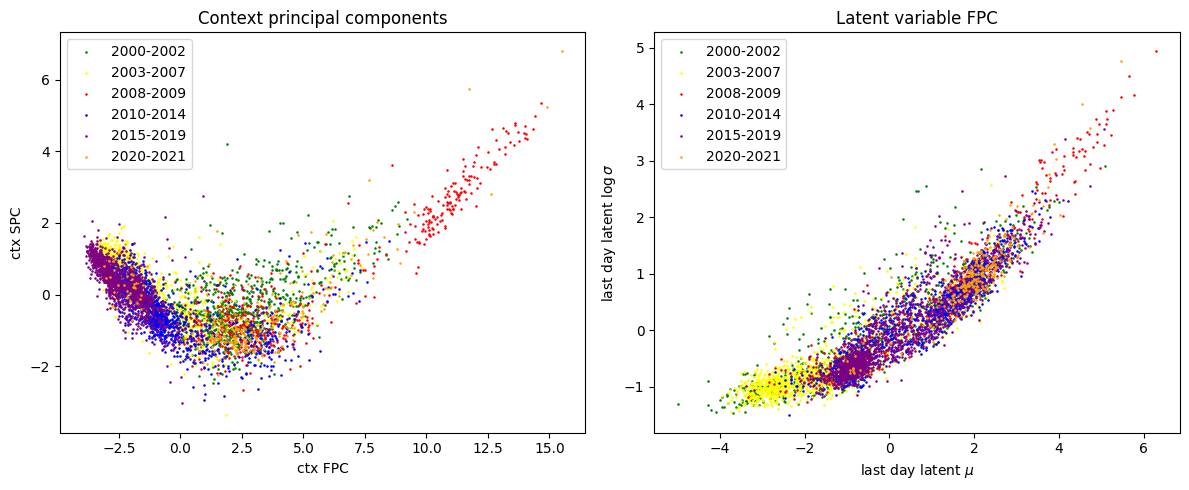

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for period_date, period_title, period_range, color in periods:
    subset_df = df[df["date"].isin(period_range)].copy()
    ax[0].scatter(subset_df["ctx_dim0"], subset_df["ctx_dim1"], s=0.7, c=color, label=period_date)
    ax[1].scatter(subset_df["z_mu"], subset_df["z_log_sig"], s=0.7, c=color, label=period_date)

ax[0].set_xlabel("ctx FPC")
ax[0].set_ylabel("ctx SPC")
ax[0].set_title("Context principal components")
ax[0].legend()
ax[1].set_xlabel("last day latent $\mu$")
ax[1].set_ylabel("last day latent $\log \sigma$")
ax[1].set_title("Latent variable FPC")
ax[1].legend()
plt.tight_layout()
plt.show()